## U-Net segmentation

In [2]:
# urls to download images and annotations:
# https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

# set the necessary paths
# choose parameters depending on hardware capabilities
# check if the data has been downloaded correctly
import os

input_dir = './images/'
target_dir = './annotations/trimaps/'

# object, background, uncertain area between
num_classes = 3

img_size = (160, 160)
batch_size = 16

# folder + file paths
input_img_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith('.jpg')
])

target_img_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith('.png') and not fname.startswith('.')
])

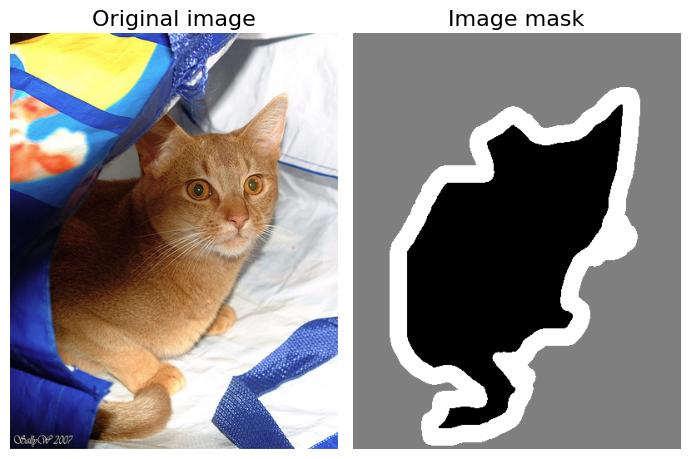

In [3]:
# show an example image and the corresponding mask
import matplotlib.pyplot as plt
import PIL
from keras.preprocessing.image import load_img

# reading image and its mask
image = load_img(input_img_paths[2])
mask = load_img(target_img_paths[2])
mask = PIL.ImageOps.autocontrast(mask)

# plotting the results
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 15))
ax[0].set_title("Original image", fontsize=16)
ax[0].imshow(image)
ax[0].axis('off')

ax[1].set_title("Image mask", fontsize=16)
ax[1].imshow(mask)
ax[1].axis('off')

plt.tight_layout()
plt.show()

### Data generator

In [4]:
from keras import utils
import numpy as np

# for our custom class to function as a generator and be usable, for example, by fit,
# it must have three definitions: __init__, __len__, and __getitem__
class DataGen(utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths


    def __len__(self):
        return (len(self.target_img_paths) - 1) // self.batch_size + 1


    # returns tuple (input, target) corresponding to batch idx
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_size = min(self.batch_size, len(self.input_img_paths) - i)
        batch_input_img_paths = self.input_img_paths[i : i + batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype=np.float32)
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype=np.uint8)

        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)

            # ground truth labels are 1, 2, 3 - subtract one to make them 0, 1, 2
            y[j] -= 1

        return x, y

### Network architecture

In [5]:
from keras import layers

# helper block definitions
# convolutional block
def double_conv_block(x, n_filters):
    # remember to add padding
    x = layers.Conv2D(
        n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal'
    )(x)

    x = layers.Conv2D(
        n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal'
    )(x)

    return x


# downsampling block
def downsample_block(x, n_filters):
    x = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(x)
    p = layers.Dropout(0.3)(p)

    return x, p


# upsampling block
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)

    return x

In [6]:
import keras

def get_model(img_size, num_classes):
    inputs = layers.Input(shape=(*img_size, 3))

    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    bottleneck = double_conv_block(p4, 1024)

    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    outputs = layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(u9)
    unet_model = keras.Model(inputs, outputs, name='U-Net')

    return unet_model


keras.backend.clear_session()
model = get_model(img_size, num_classes)

# verifying model architecture
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 160, 160,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 160, 160,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 80, 80,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 80, 80,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 80, 80,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 80, 80,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 40, 40,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 40, 40,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 40, 40,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 40, 40,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 20, 20,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 20, 20,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 20, 20,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 20, 20,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 10, 10,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 10, 10,    │          0 │ max_pooling2d_3[

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

### Data preparation

In [7]:
# divide the data into training set and validation set (based on paths)
import random

random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)

input_size = int(len(input_img_paths))
validation_size = int(0.1 * len(input_img_paths))

train_input_img_paths = input_img_paths[:-validation_size]
train_target_img_paths = target_img_paths[:-validation_size]
val_input_img_paths = input_img_paths[-validation_size:]
val_target_img_paths = target_img_paths[-validation_size:]

In [8]:
# data generators
train_gen = DataGen(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = DataGen(batch_size, img_size, val_input_img_paths, val_target_img_paths)

### Training the model

In [9]:
callbacks = [keras.callbacks.ModelCheckpoint("unet.h5", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.fit(train_gen, epochs=15, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 8638.2842

416/416 ━━━━━━━━━━━━━━━━━━━━ 266s 519ms/step - loss: 8621.2666 - val_loss: 0.9246
Epoch 2/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 0.9061

416/416 ━━━━━━━━━━━━━━━━━━━━ 161s 388ms/step - loss: 0.9061 - val_loss: 0.8859
Epoch 3/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - loss: 0.8831

416/416 ━━━━━━━━━━━━━━━━━━━━ 157s 377ms/step - loss: 0.8831 - val_loss: 0.8620
Epoch 4/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - loss: 0.8702

416/416 ━━━━━━━━━━━━━━━━━━━━ 161s 386ms/step - loss: 0.8702 - val_loss: 0.8102
Epoch 5/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 0.7944

416/416 ━━━━━━━━━━━━━━━━━━━━ 164s 393ms/step - loss: 0.7943 - val_loss: 0.6242
Epoch 6/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 0.6492

416/416 ━━━━━━━━━━━━━━━━━━━━ 158s 380ms/step - loss: 0.6491 - val_loss: 0.5748
Epoch 7/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 0.5514

416/416 ━━━━━━━━━━━━━━━━━━━━ 158s 379ms/step - loss: 0.5514 - val_loss: 0.4669
Epoch 8/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 157s 376ms/step - loss: 0.4982 - val_loss: 0.7678
Epoch 9/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 157s 376ms/step - loss: 0.4601 - val_loss: 0.4932
Epoch 10/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 0.4175

416/416 ━━━━━━━━━━━━━━━━━━━━ 163s 393ms/step - loss: 0.4175 - val_loss: 0.3945
Epoch 11/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 157s 377ms/step - loss: 0.3851 - val_loss: 0.4491
Epoch 12/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 0.3712

416/416 ━━━━━━━━━━━━━━━━━━━━ 163s 391ms/step - loss: 0.3712 - val_loss: 0.3514
Epoch 13/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 156s 376ms/step - loss: 0.3620 - val_loss: 0.3652
Epoch 14/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 0.3372

416/416 ━━━━━━━━━━━━━━━━━━━━ 158s 379ms/step - loss: 0.3372 - val_loss: 0.3242
Epoch 15/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 0.3229

416/416 ━━━━━━━━━━━━━━━━━━━━ 163s 392ms/step - loss: 0.3229 - val_loss: 0.3103
